In [17]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [3]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61406 sha256=5bfe91d8cd406a6cd9ee20d0bdc92f3f1d4a696b13f2358d63d988b573e8bb15
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31530 sha256=83e6b798b9f063f31ce5abba20a935a6694df61fad0db26eb65b8f99a78d4251
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 208.2 MB/s eta 0:00:00


In [25]:
import torch
from pytorch3d.io import load_obj, save_obj, load_objs_as_meshes
from pytorch3d.structures import Meshes
from pytorch3d.structures import Volumes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    SoftPhongShader,
    MeshRasterizer,
    TexturesUV,
    TexturesAtlas,
    FoVPerspectiveCameras,
    VolumeRenderer,
    NDCMultinomialRaysampler,
    EmissionAbsorptionRaymarcher
)
from torchvision.utils import make_grid

import numpy as np

from tqdm.notebook import tqdm

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['savefig.dpi']=80
# mpl.rcParams['figure.dpi']=80

if torch.cuda.is_available():
  device=torch.device("cuda:0")
else:
  device=torch.device('cpu')
  print('cannot find gpu')



In [5]:
!pwd

/content


In [6]:
!ls

drive  sample_data


In [7]:
import os
os.chdir('drive/MyDrive/Colab Notebooks')

In [8]:
!ls

 1_b.gif
 2.1.gif
 3_b.gif
'camera_position_optimization(problem).ipynb'
 data
 deform_form.ipynb
 fit_mesh_via_rendering.ipynb
 plot_image_grid.py
 plot_image_grid.py.1
 plotly_rendered_meshes.ipynb
 __pycache__
 q_5-1_pc1.gif
 q_5-1_pc2.gif
 q_5-1_pc_union.gif
 q_5-2.gif
 q_5-3.gif
 rendering_generic_3d_representations.ipynb
 rendering_parametric_and_implicit.ipynb
 rendering_point_clouds_from_rgbd.ipynb
 rendering_texture_obj.ipynb
 render_tetrahedron_and_retexturing.ipynb
 render_texture_mesh_and_dolly_zoom.ipynb
'sample_pointcloud_from_mesh(problem).ipynb'
 tea_pot.gif
 volume_rendering_raymatching.ipynb


In [ ]:
!ls

data  deform_form.ipynb  rendering_texture_obj.ipynb


In [18]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

--2023-08-11 01:47:19--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.4’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0.001s  

2023-08-11 01:47:19 (1.75 MB/s) - ‘plot_image_grid.py.4’ saved [1608/1608]

--2023-08-11 01:47:19--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reques

In [19]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
from plot_image_grid import image_grid
from generate_cow_renders import generate_cow_renders

--2023-08-11 01:47:21--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py.5’

plot_image_grid.py. 100%[===================>]   1.57K  --.-KB/s    in 0.003s  

2023-08-11 01:47:21 (458 KB/s) - ‘plot_image_grid.py.5’ saved [1608/1608]

--2023-08-11 01:47:21--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/generate_cow_renders.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request

In [20]:
target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

Generated 40 images/silhouettes/cameras.


In [23]:
# render_size describes the size of both sides of the
# rendered images in pixels. We set this to the same size
# as the target images. I.e. we render at the same
# size as the ground truth images.
render_size = target_images.shape[1]

# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
volume_extent_world = 3.0

# 1) Instantiate the raysampler.
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
# Since we use a volume of size 128^3, we sample n_pts_per_ray=150,
# which roughly corresponds to a one ray-point per voxel.
# We further set the min_depth=0.1 since there is no surface within
# 0.1 units of any camera plane.
raysampler = NDCMultinomialRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)


# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# each ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the volumetric render
# with the raysampler and raymarcher objects.
renderer = VolumeRenderer(
    raysampler=raysampler, raymarcher=raymarcher,
)

In [26]:
class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        # After evaluating torch.sigmoid(self.log_colors), we get
        # densities close to zero.
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        # After evaluating torch.sigmoid(self.log_colors), we get
        # a neutral gray color everywhere.
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        # Store the renderer module as well.
        self._renderer = renderer

    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        # Convert the log-space values to the densities/colors
        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)

        # Instantiate the Volumes object, making sure
        # the densities and colors are correctly
        # expanded batch_size-times.
        volumes = Volumes(
            densities = densities[None].expand(
                batch_size, *self.log_densities.shape),
            features = colors[None].expand(
                batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )

        # Given cameras and volumes, run the renderer
        # and return only the first output value
        # (the 2nd output is a representation of the sampled
        # rays which can be omitted for our purpose).
        return self._renderer(cameras=cameras, volumes=volumes)[0]

# A helper function for evaluating the smooth L1 (huber) loss
# between the rendered silhouettes and colors.
def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss

In [27]:
# First move all relevant variables to the correct device.
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Instantiate the volumetric model.
# We use a cubical volume with the size of
# one side = 128. The size of each voxel of the volume
# is set to volume_extent_world / volume_size s.t. the
# volume represents the space enclosed in a 3D bounding box
# centered at (0, 0, 0) with the size of each side equal to 3.
volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3,
    voxel_size = volume_extent_world / volume_size,
).to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 0.1.
lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

# We do 300 Adam iterations and sample 10 random images in each minibatch.
batch_size = 10
n_iter = 300
for iteration in range(n_iter):

    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.
    if iteration == round(n_iter * 0.75):
        print('Decreasing LR 10-fold ...')
        optimizer = torch.optim.Adam(
            volume_model.parameters(), lr=lr * 0.1
        )

    # Zero the optimizer gradient.
    optimizer.zero_grad()

    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R = target_cameras.R[batch_idx],
        T = target_cameras.T[batch_idx],
        znear = target_cameras.znear[batch_idx],
        zfar = target_cameras.zfar[batch_idx],
        aspect_ratio = target_cameras.aspect_ratio[batch_idx],
        fov = target_cameras.fov[batch_idx],
        device = device,
    )

    # Evaluate the volumetric model.
    rendered_images, rendered_silhouettes = volume_model(
        batch_cameras
    ).split([3, 1], dim=-1)

    # Compute the silhoue

Decreasing LR 10-fold ...


Generating rotating volume ...


  0%|          | 0/28 [00:00<?, ?it/s]

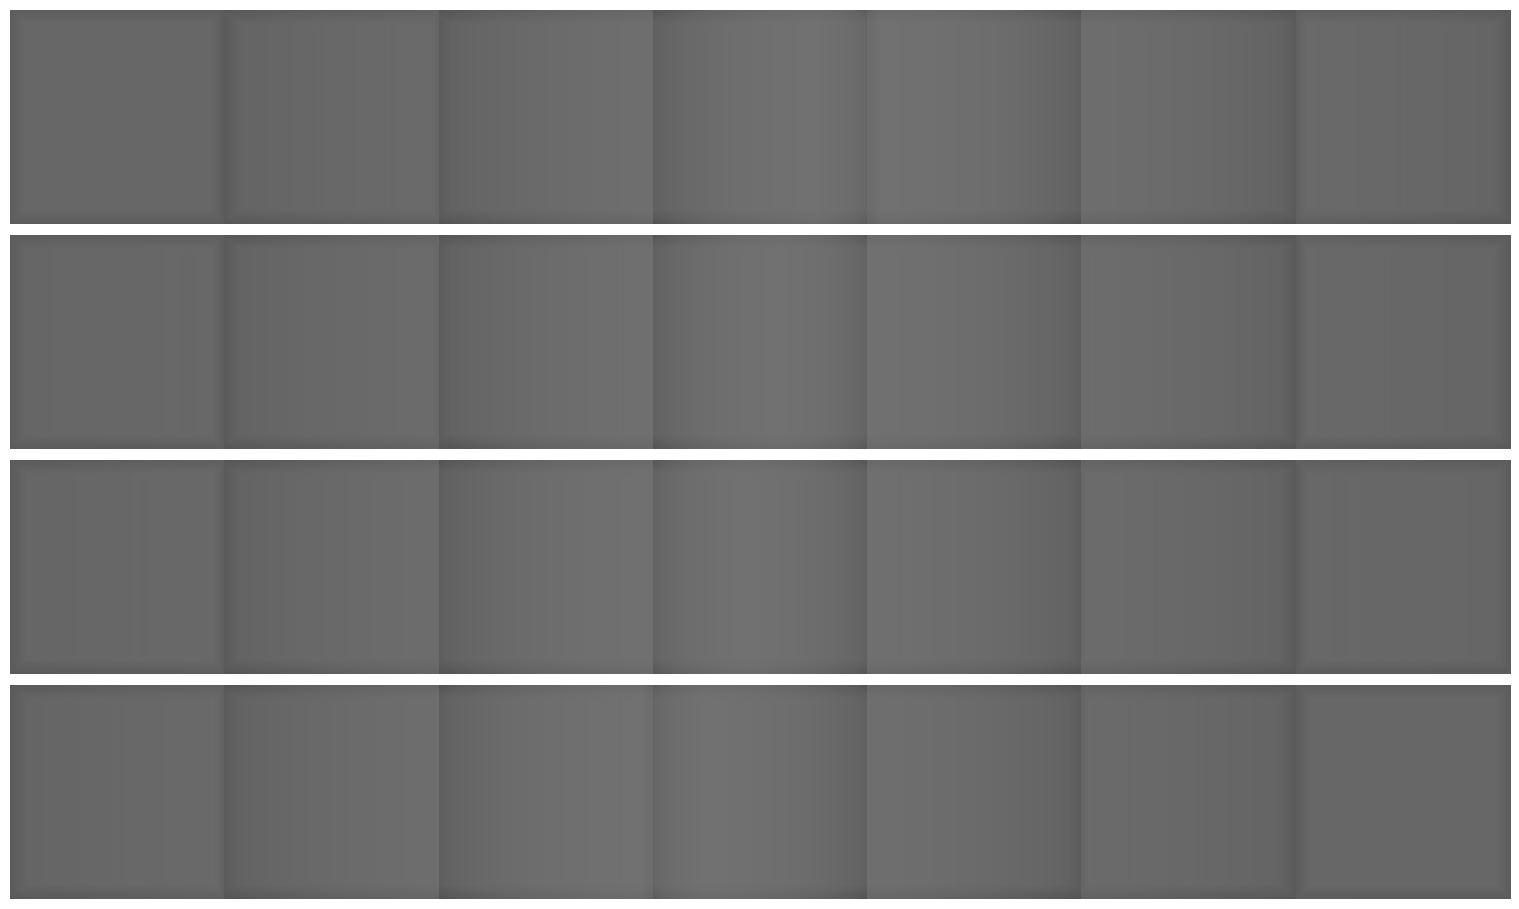

In [29]:
from pytorch3d.transforms import so3_exp_map



def generate_rotating_volume(volume_model, n_frames = 50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print('Generating rotating volume ...')
    for R, T in zip(tqdm(Rs), Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear = target_cameras.znear[0],
            zfar = target_cameras.zfar[0],
            aspect_ratio = target_cameras.aspect_ratio[0],
            fov = target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)

with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7*4)

image_grid(rotating_volume_frames.clamp(0., 1.).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
plt.show()